# Salary recommandation using a score


Author: Florian Gauthier

The purpose of this Notebook is to find the best score in order to select the optimal salary change in the salary-based recommendation. 

The best score will be the one that allows the best compromise between a salary decrease and a raise in job offers, for every job groups & experience buckets.


We first use the 10% sample (~1.2Go) dataset called `sample_10perc.csv` because the full dataset is too big.


In [1]:
import numpy as np
import pandas as pd
from pandas.tseries import offsets
from paul_emploi.lib import cleaned_data
from paul_emploi.modeling import salary_recommendation_model, job_offers_optimal_buckets
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

## Import & clean job postings dataset

Let's first `import_clean_job_offers` to import a clean database of job_offers.


In [4]:
etalab_path = "/var/data/bayes_impact/"
postings = cleaned_data.job_offers(data_folder=etalab_path, filename_offers="job_offers/sample_10perc.csv")
postings.head(2)

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (1,2,6,7,10,11,20,21,23,24,27,28,30,31,32,37,38,39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,92,94,95,96,97,98,100,102,104,105,106,107,108,109,110,111,112,115,119,120,124,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,id_offre,date_debut_validite_offre,date_fin_validite_offre,nb_vacancies_creation,status_code,status_name,experience_code,experience_name,experience_min_duration,experience_max_duration,...,monitoring_agency_code,employer_consent,number_of_application,nb_vacancies_left,latitude,longitude,eff_cle,rome_id,rome_name,date_debut_imputed
0,000053Q,NaT,NaN,1,AN,Annulée,E,Expérience exigée,60,0,...,79035.0,NaN,NaN,0,46.65,-0.25,NaN,F1106,Ingénierie et études du BTP,2012-08-16
1,000129Q,NaT,NaN,1,AN,Annulée,D,Débutant accepté,0,0,...,86061.0,NaN,NaN,0,46.6667,0.066667,NaN,G1204,Éducation en activités sportives,2012-08-17


## Filter postings
Remove outliers & filter date.

These modules will not be used in production since the filtering will be done before without pandas.


In [5]:
# Since our sample has data until early 2016, we use for now SMIC
# 2015 to run some tests. As a maximum salary, we use 50.000€ (which is
# arbitrary.)
# SMIC amounts available here: http://www.salairebrutnet.fr/
SMIC_2015 = 17496
SMIC_2016 = 17604
_MIN_ANNUAL_SALARY = SMIC_2015
# Arbitrary.
_MAX_ANNUAL_SALARY = 50000


def filter_postings(
        table_offers,
        min_salary=_MIN_ANNUAL_SALARY,
        max_salary=_MAX_ANNUAL_SALARY,
        nb_months=6):
    """Returns a table containing only job offers that fulfill specific
    criteria. It will be used for salary recommendations.
    Args :
        table_offers: pandas DataFrame containing job postings.
        min_salary (int.): exclude all salary under min_salary (ex : SMIC).
        max_salary (int.): exclude all salary above max_salary (ex: 50000).
        nb_months: number of months to look back to get job offers.
    Returns:
        a pandas DataFrame containing only job offers that fulfill specific
        criteria. It will be used for salary recommendations.
    """
    clean_postings = table_offers.copy()
    # Exclude outliers.
    clean_postings = _filter_outliers(
        clean_postings, min_salary, max_salary)

    # Grab every offers until nb_months before.
    if not clean_postings.empty:  # Or it will crash.
        clean_postings = _filter_date(clean_postings, nb_months)

    # Check if table is not empty.
    if clean_postings.empty:
        raise ValueError('No job offers match the given criteria.')

    interesting_cols = [
        'rome_id',
        'annual_minimum_salary',
        'experience_min_duration']
    return clean_postings[interesting_cols]


def _filter_date(table_offers, nb_months):
    """ Keep only the latest nb_months of the postings dataset.
    Args :
        table_offers: pandas DataFrame containing job postings.
        nb_months (int.): number of months to look back to get job offers.
    Returns:
        pandas DataFrame contaning offers of the latest nb_months
        of table_offers.
    """
    table_offers.set_index(pd.DatetimeIndex(
        table_offers.date_debut_imputed), inplace=True)
    end_date = table_offers.date_debut_imputed.max()
    start_date = (end_date - offsets.DateOffset(months=nb_months)).strftime(
        '%Y-%m-%d')
    date_mask = (table_offers['date_debut_imputed'] >= start_date)
    return table_offers.loc[date_mask].reset_index(drop=True)

def _filter_outliers(
        table_offers,
        min_salary,
        max_salary):
    """Returns a table containing only job offers without outliers.
    Args :
        table_offers: pandas DataFrame containing job postings.
        min_salary (int.): exclude all salary under min_salary (ex : SMIC).
        max_salary (int.): exclude all salary above max_salary (ex: 50000).
    Returns:
        pandas DataFrame containing only job offers with a salary between
        [min_salary, max_salary[.
    """
    valid_salary_mask = (table_offers.annual_minimum_salary >= min_salary) & (
        table_offers.annual_minimum_salary < max_salary)
    return table_offers.loc[valid_salary_mask]

In [6]:
clean_postings = filter_postings(postings)
clean_postings.head(2)

,rome_id,annual_minimum_salary,experience_min_duration
0,K2303,17526.6,0
1,I1304,28000.0,36


### Make experience buckets

In [7]:
# Select some job groups (some contaning offers, other without so many)
job_groups_examples = [
    'G1602',
    'K2204',
    'K1303',
    'K1304',
    'G1803',
    'A1202',
    'B1401']

postings_example = clean_postings.loc[clean_postings.rome_id.isin(job_groups_examples)]

# Bucketize
postings_example_bucketized = postings_example.groupby('rome_id').apply(
    job_offers_optimal_buckets.apply_bucketize)

postings_example_bucketized.head(5)

,rome_id,annual_minimum_salary,experience_min_duration,exp_bucket
13,G1602,18000.0,0,"[0, 1["
24,K2204,17945.2,0,"[0, 1["
57,G1602,30000.0,36,"[36, 48["
64,G1803,24000.0,12,"[7, 24["
76,G1803,21600.0,6,"[6, 7["


### Let's create 2 small subsets

Each of them contains a single `exp_bucket` of a `rome_id`.

In [8]:
# Make a dataset contaning only 1 job group & 1 experience bucket

postings_mask_1 = (postings_example_bucketized.rome_id == 'G1602') &\
    (postings_example_bucketized.exp_bucket == '[0, 1[')
    
postings_mask_2 = (postings_example_bucketized.rome_id == 'G1803') &\
    (postings_example_bucketized.exp_bucket == '[0, 1[')
    
postings_1 = postings_example_bucketized.loc[postings_mask_1]
postings_2 = postings_example_bucketized.loc[postings_mask_2]

postings_2.head(2)

,rome_id,annual_minimum_salary,experience_min_duration,exp_bucket
89,G1803,18000.00,0,"[0, 1["
420,G1803,19489.08,0,"[0, 1["


### Cumulative counts

For each salary, we count the number of offers available.

In [9]:
num_offers_with_higher_salary = salary_recommendation_model._compute_job_offers_salary(postings_1)
num_offers_with_higher_salary.head(2)

annual_minimum_salary
17496.00    343
17508.72    332
Name: num_offers_with_higher_salary, dtype: int64

## Chosing the best score

We use the following modules to compute graphs on score.

In [10]:
def compute_result_as_df(table_offers, score_label='sqrtO_salary'):
    """ Compute every metrics of the score and store them in a pandas Dataframe
    """
    num_offers_with_higher_salary = salary_recommendation_model._compute_job_offers_salary(
        table_offers)
    cumul_offers = num_offers_with_higher_salary.reset_index()
    def _scoring(idx):
        return _apply_score(num_offers_with_higher_salary, idx, score_label=score_label)

    result_as_df = pd.DataFrame(cumul_offers.reset_index()['index'].apply(_scoring).tolist())
    result_as_df = pd.concat([cumul_offers, result_as_df], axis=1)
    
    return result_as_df


def _apply_score(
        num_offers_with_higher_salary, idx, score_label):
    """ Calculate a score to each salaries of table_offers, maximize it and return the amount of
    gained offers for the optimal decrease of salary + additional metrics to compute 
    score comparison.

    Args:
        num_offers_with_higher_salary: Pandas Series containing the amount of job offers (value)
            by salary (index).
        idx: the index of the salary on which to compute the score.
        score_label: label of the score we decided to compute.

    Returns:
        a dictionnary containing all the metrics

    """
    # Cumulative count.
    cumul_offers = num_offers_with_higher_salary.reset_index()
    if idx == 0:
        return _fill_dict_of_res(0, cumul_offers.annual_minimum_salary.iloc[idx], 0, 0)

    delta_salaries = salary_recommendation_model._compute_delta_from_index(
        cumul_offers.annual_minimum_salary, idx)
    delta_offers = salary_recommendation_model._compute_delta_from_index(
        cumul_offers.num_offers_with_higher_salary, idx)
    # Compute score.
    scores = _compute_scores(delta_offers, delta_salaries, score_label)
    # Best score = max(score).
    idx_max_score = scores.idxmax()
    # Compute results.
    final_num_offers = cumul_offers.num_offers_with_higher_salary.iloc[idx_max_score]
    final_salary = cumul_offers.annual_minimum_salary.iloc[idx_max_score]
    gained_offers = delta_offers.iloc[idx_max_score]
    decrease_of_salary = delta_salaries.iloc[idx_max_score]

    return _fill_dict_of_res(idx_max_score, final_salary, decrease_of_salary, gained_offers)


def _fill_dict_of_res(idx_max_score, final_salary, decrease_of_salary, gained_offers):
    return {
        'idx_max_score': idx_max_score,
        'final_salary': final_salary,
        'decrease_of_salary': decrease_of_salary,
        'gained_offers': gained_offers}


def _compute_scores(offers, delta_salaries, score_label):
    """Compute different scores
    NOTE: 'O' stands for 'delta(O)' and 'S' stands for 'delta(S)', with 'delta(O)' being the variation
    of number of offers and 'delta(S)' the respective variation of salary.
    """
    if score_label == 'sqrt(O)_S':
        score = np.sqrt(offers) / (delta_salaries)
    if score_label == 'sqrt(O)_S²':
        score = np.sqrt(offers) / (delta_salaries ** 2)
    if score_label == 'log(O)_S':
        score = np.log(offers) / (delta_salaries)
    if score_label == 'log(O)_S²':
        score = np.log(offers) / (delta_salaries ** 2)
    if score_label == 'O_S²':
        score = offers / (delta_salaries ** 2)

    return score

In [11]:
table_offers = postings_1.copy()
#table_offers = postings_2.copy()

In [12]:
# Output example
result_as_df = compute_result_as_df(table_offers=table_offers, score_label='sqrt(O)_S')
result_as_df.head(2)

,annual_minimum_salary,num_offers_with_higher_salary,decrease_of_salary,final_salary,gained_offers,idx_max_score
0,17496.00,343,0.000000,17496.0,0.000000,0
1,17508.72,332,-0.000726,17496.0,0.033133,0


## Score comparaison

We're going to compare scores relatively to 3 metrics :

* Recommended salaries
* Recommended decrease of salary
* Gained offers

### Recommended salaries

* x-axis: salary indexes in ascending values (0: the lowest salary)
* y-axis: recommended salary indexes (also in ascending values).

In [13]:
score_label_list = ['sqrt(O)_S', 'sqrt(O)_S²', 'log(O)_S', 'log(O)_S²', 'O_S²']
col_list = ['blue', 'green', 'red', 'darkturquoise', 'purple']

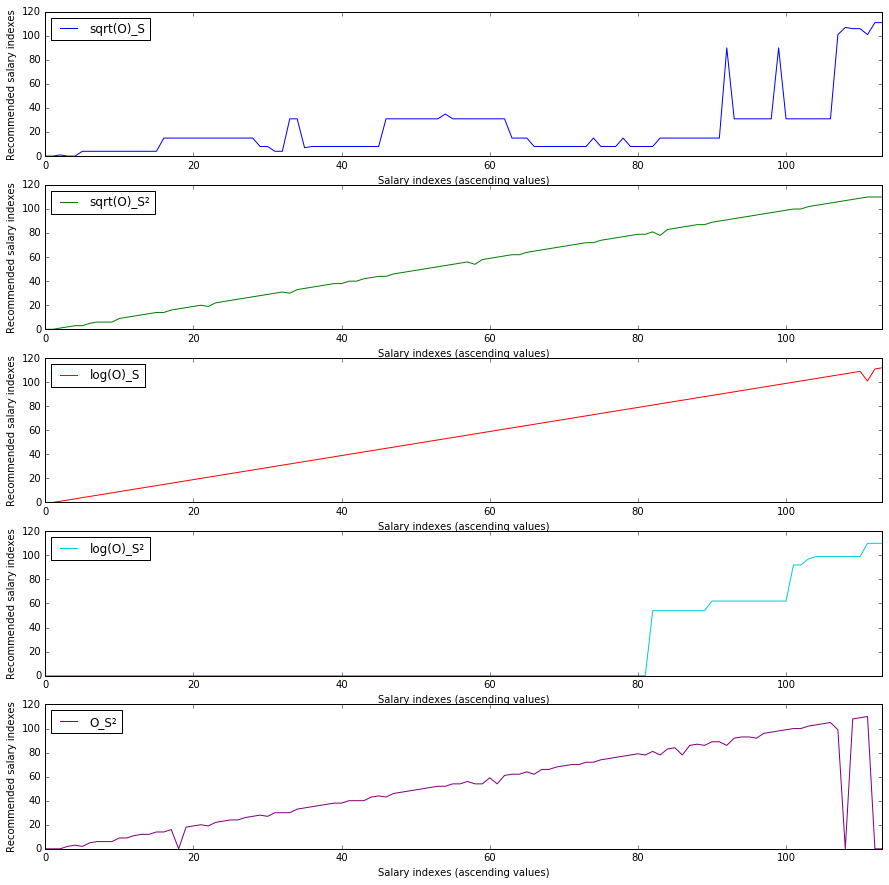

In [14]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(len(score_label_list), 1)
num_fig = 0
num_col = 0
for score_label in score_label_list:
    ax = plt.subplot(gs[num_fig])
    result_as_df = compute_result_as_df(table_offers=table_offers, score_label=score_label)
    result_as_df.idx_max_score.plot(label=score_label, ax=ax, color=col_list[num_col])
    plt.xlabel('Salary indexes (ascending values)')
    plt.ylabel('Recommended salary indexes')
    plt.legend(loc='upper left')
    num_fig += 1
    num_col += 1

### Recommended decrease of salary

* x-axis: annual_minimul salary in ascending values
* y-axis: recommended decrease of salary

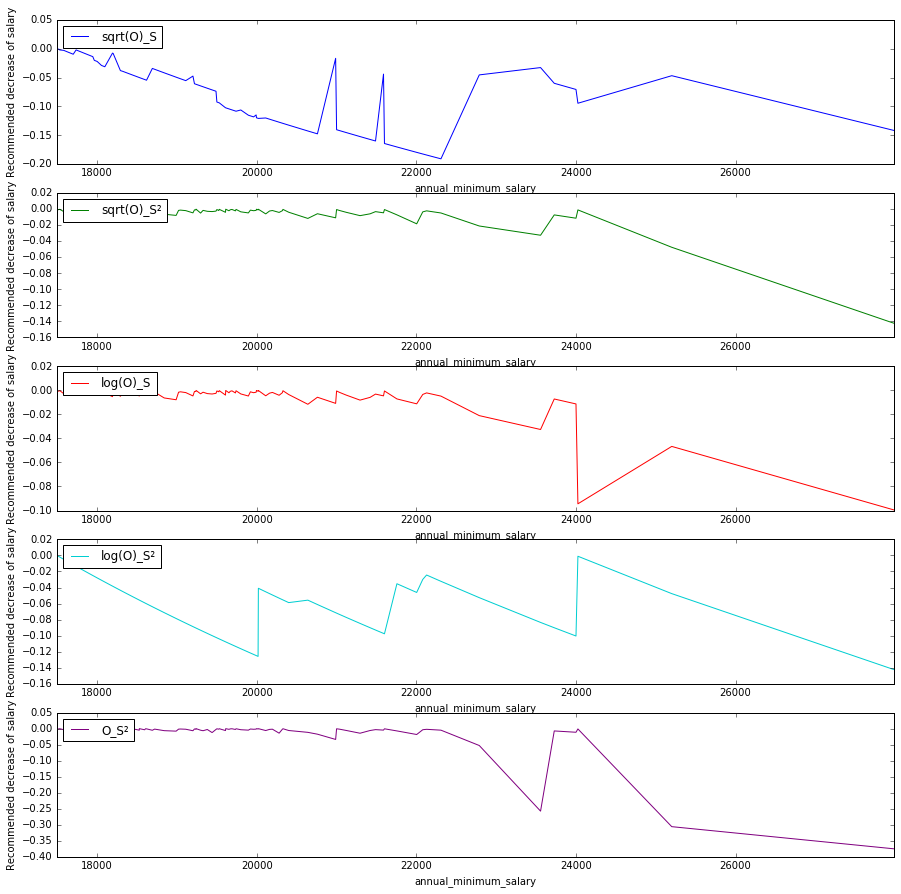

In [15]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(len(score_label_list), 1)
num_fig = 0
num_col = 0
for score_label in score_label_list:
    ax = plt.subplot(gs[num_fig])
    result_as_df = compute_result_as_df(table_offers=table_offers, score_label=score_label)
    result_as_df.set_index('annual_minimum_salary').decrease_of_salary.plot(
        label=score_label, ax=ax, color=col_list[num_col])
    plt.ylabel('Recommended decrease of salary')
    plt.legend(loc='upper left')
    num_fig += 1
    num_col += 1

### Gained offers

* x-axis: annual_minimul salary in ascending values
* y-axis: Gained offers in percent.

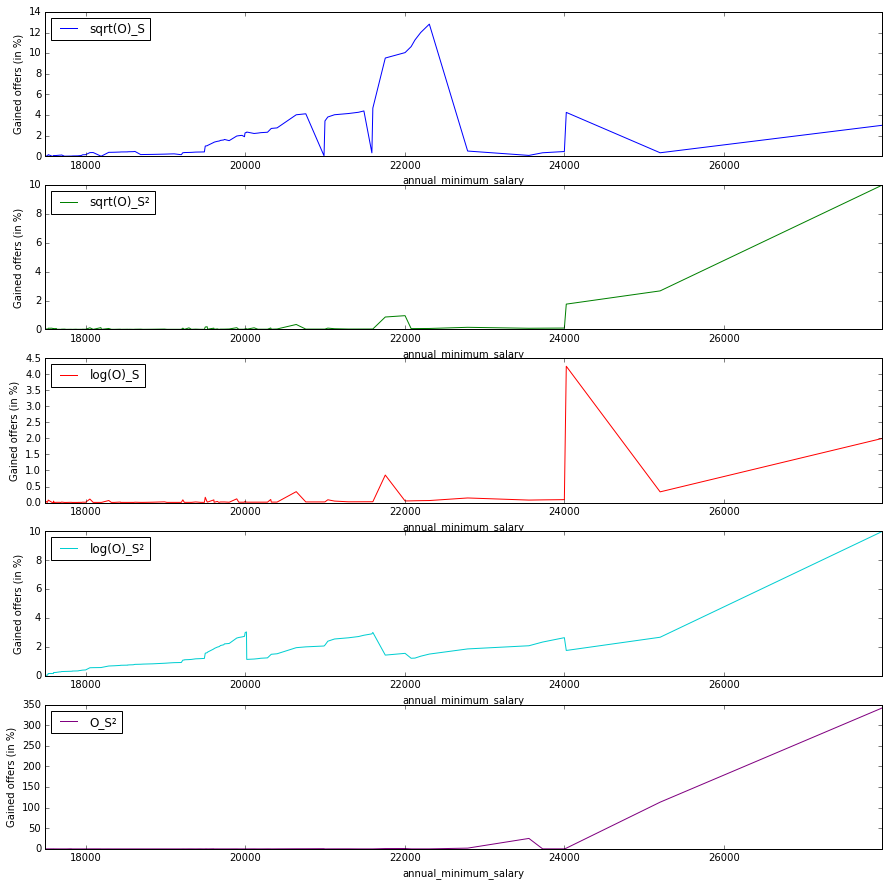

In [16]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(len(score_label_list), 1)
num_fig = 0
num_col = 0
for score_label in score_label_list:
    ax = plt.subplot(gs[num_fig])
    result_as_df = compute_result_as_df(table_offers=table_offers, score_label=score_label)
    result_as_df.set_index('annual_minimum_salary').gained_offers.plot(label=score_label, ax=ax, color=col_list[num_col])
    plt.ylabel('Gained offers (in %)')
    plt.legend(loc='upper left')
    num_col += 1
    num_fig += 1


## And the best score is....

* `sqrt(O)/S` seems to be the best score.

* `ln(O)/S ` and ` sqrt(O)/S` both give too much weight to `salary variation` and we end up always recommending the preceding salary (see first graphs on "Recommended salaries").

* `O/S²` gives too much weight on salary when the latter starts to grow up to a certain point. Then it recommends way too high decrease of salary.

NOTE: `O=delta(O)` being the variation of number of offers and `S=delta(S)` the respective variation of salary.
